In [1]:
import sys
import logging
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import icesat2

In [2]:
# Configure Session
logging.basicConfig(level=logging.INFO)
icesat2.init("http://44.227.4.67:9081", False)

In [4]:
# Build ATL06 Request
parms = {
    "poly": [ {"lon": -108.3435200747503, "lat": 38.89102961045247},
              {"lon": -107.7677425431139, "lat": 38.90611184543033}, 
              {"lon": -107.7818591266989, "lat": 39.26613714985466},
              {"lon": -108.3605610678553, "lat": 39.25086131372244},
              {"lon": -108.3435200747503, "lat": 38.89102961045247} ],
    "cnf": 4,
    "ats": 20.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
     "maxi": 1
}

# Request ATL06 Data
rsps = icesat2.atl06p(parms, "atl03-cloud")

# Build Dataframe of SlideRule Responses
df = pd.DataFrame(data=list(zip(rsps["h_mean"], rsps["lat"], rsps["lon"], rsps["spot"])), index=rsps["segment_id"], columns=["h_mean", "latitude", "longitude", "spot"])

CRITICAL:sliderule.sliderule:atl06 processing initiated on ATL03_20181114092019_07140106_003_01.h5 ...
CRITICAL:sliderule.sliderule:atl06 processing initiated on ATL03_20181017222812_02950102_003_01.h5 ...
CRITICAL:sliderule.sliderule:atl06 processing initiated on ATL03_20181110092841_06530106_003_01.h5 ...
CRITICAL:sliderule.sliderule:atl06 processing initiated on ATL03_20181115210428_07370102_003_01.h5 ...
CRITICAL:sliderule.sliderule:... continuing to read ATL03_20181114092019_07140106_003_01.h5 (after 10 seconds)
CRITICAL:sliderule.sliderule:... continuing to read ATL03_20181110092841_06530106_003_01.h5 (after 10 seconds)
CRITICAL:sliderule.sliderule:... continuing to read ATL03_20181017222812_02950102_003_01.h5 (after 10 seconds)
CRITICAL:sliderule.sliderule:... continuing to read ATL03_20181115210428_07370102_003_01.h5 (after 10 seconds)
CRITICAL:sliderule.sliderule:... continuing to read ATL03_20181114092019_07140106_003_01.h5 (after 20 seconds)
CRITICAL:sliderule.sliderule:... 

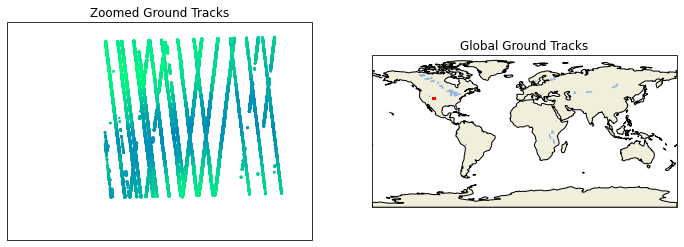

In [5]:
# Create Plot
fig = plt.figure(num=None, figsize=(12, 6))

# Plot Ground Tracks
ax1 = plt.subplot(121,projection=cartopy.crs.PlateCarree())
ax1.set_title("Zoomed Ground Tracks")
ax1.scatter(df["longitude"].values, df["latitude"].values, s=2.5, c=df["h_mean"], cmap='winter_r', zorder=3, transform=cartopy.crs.PlateCarree())
ax1.set_extent((-108.4,-107.7,38.8,39.3),crs=cartopy.crs.PlateCarree())

# Plot Global View
ax2 = plt.subplot(122,projection=cartopy.crs.PlateCarree())
ax2.set_title("Global Ground Tracks")
ax2.scatter(df["longitude"].values, df["latitude"].values, s=2.5, color='r', zorder=3, transform=cartopy.crs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax2.add_feature(cartopy.feature.LAKES)
ax2.set_extent((-180,180,-90,90),crs=cartopy.crs.PlateCarree())

# Show Plot
plt.show()